# Ultimate Technologies Inc.

## Part 1 ‐ Exploratory data analysis: 
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [287]:
# Importing important module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,  RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [2]:
# Opening json file
logins = pd.read_json('logins.json')

In [3]:
# Visualizing the dataset
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
# Looking at the dataframe infos
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
# looking at the time interval
logins.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


In [6]:
# Setting time as the index
logins.set_index('login_time', inplace=True)
logins.sort_index(inplace=True)

In [7]:
# Adding a 'count' for each timestamp to enable aggregation
logins['n'] = 1

In [8]:
# Aggregating the number of logins for each 15 minute.
logins15 = logins.resample("15min").sum()
logins15.head()

,n
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Text(0.5, 1.0, 'Number of logins per year')

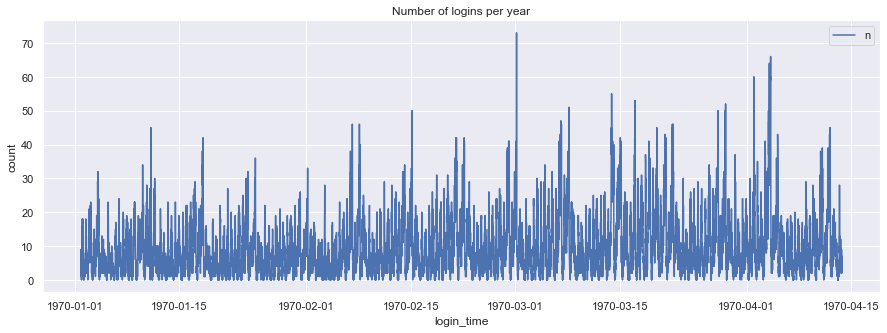

In [9]:
# Visualization of the aggregated data
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data=logins15)
plt.ylabel('count')
plt.title('Number of logins per year')

We can see some noisy cyclicity in the data with the presence of some 'spikes', which corresponds to periods of high activity (high login count). Amplitude seems to slightly increase during this 4 month period.

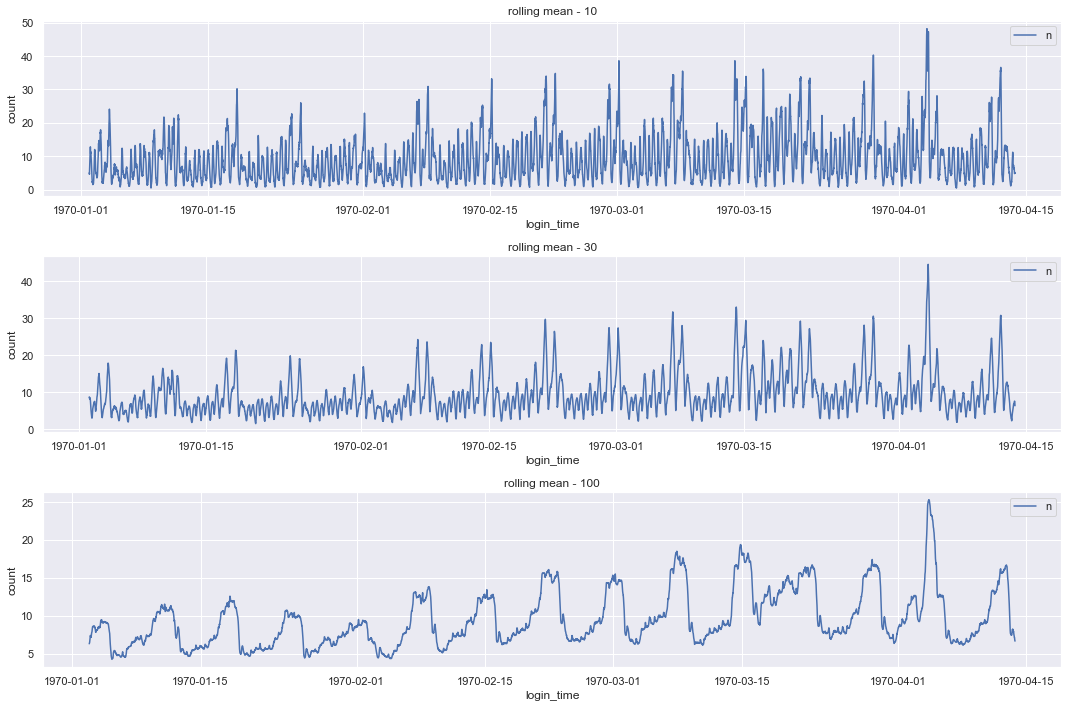

In [10]:
# Utilization of a rolling mean on the aggregated data to minimize inherent noize in the data
rolling_mean10 = logins15.rolling(10).mean()
rolling_mean30 = logins15.rolling(30).mean()
rolling_mean100 = logins15.rolling(100).mean()

sns.set(rc={'figure.figsize':(15,10)})
fig, axs = plt.subplots(nrows=3)
sns.lineplot(data=rolling_mean10, ax = axs[0])
sns.lineplot(data=rolling_mean30, ax = axs[1])
sns.lineplot(data=rolling_mean100, ax = axs[2])

axs[0].set(ylabel = 'count', title = 'rolling mean - 10')
axs[1].set(ylabel = 'count', title = 'rolling mean - 30')
axs[2].set(ylabel = 'count', title = 'rolling mean - 100')

fig.tight_layout()

We can see very clearly in the rolling mean - 100 that there are very regular occurences of "spikes". Since there is about 4 spikes per month, one could hypothesize that there is a strong weekly cyclicity to the data. 

In [63]:
# Resampling data following a 1-day period to apply seasonal decomposition
logins1440 = logins.resample("1440min").sum()
y = logins1440.n

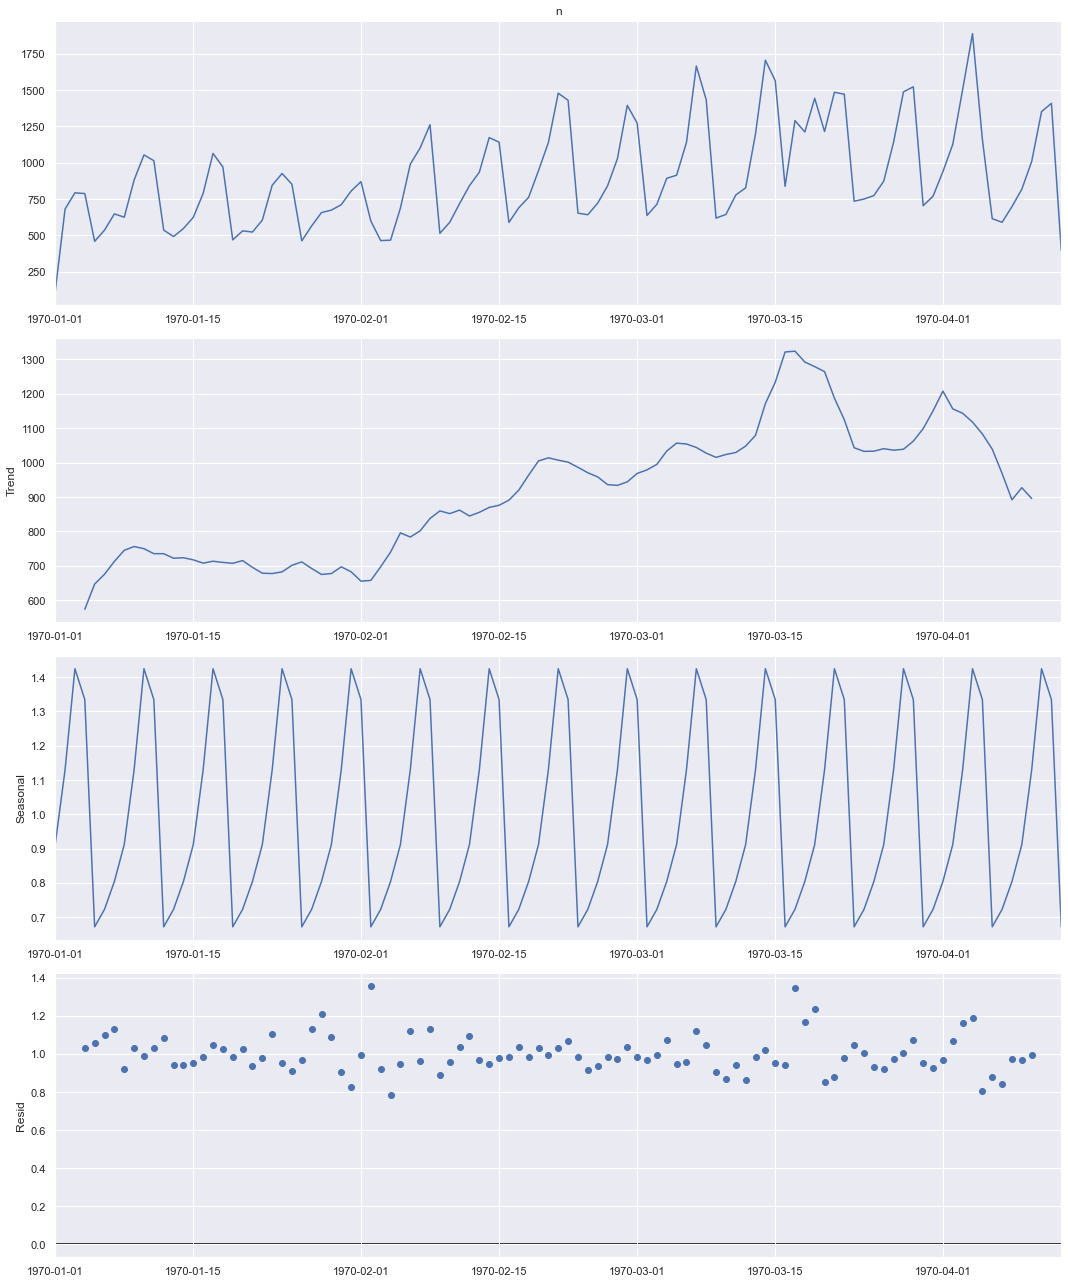

In [64]:
# Decomposing the time series
seasonal_decomp = seasonal_decompose(y, model="multiplicative")
fig = seasonal_decomp.plot()
fig.set_size_inches((15, 18))
fig.tight_layout()
plt.show()

<AxesSubplot:xlabel='weekday', ylabel='count'>

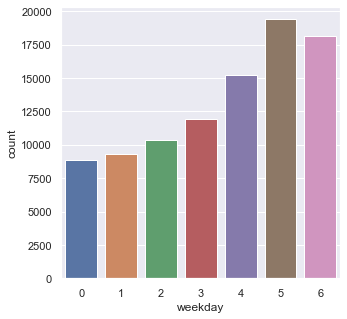

In [65]:
# Identification of the weekday to verify the weekly cyclicity in the data
# Monday=0, Sunday=6
logins = logins.assign(weekday = logins.index.weekday)
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x = logins["weekday"])

We can see that most logins occur on the weekends, mainly on saturdays. There is less logins at the begining of the week, with a gradual increase towards the end of the week. 

<AxesSubplot:xlabel='hour', ylabel='count'>

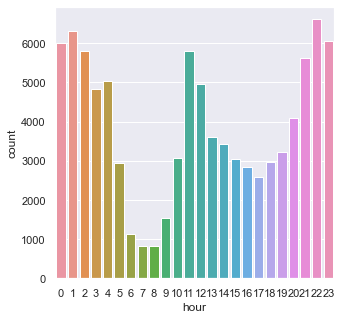

In [66]:
# Verifing daily cyclicity in the data
logins = logins.assign(hour = logins.index.hour)
sns.countplot(x = logins["hour"])

It occurs that there is more logins during the night (~21PM to 4AM) and around noon (11-12h).

## Part 2 ‐ Experiment and metrics design: 
##### Question 1: 
What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

##### Answer 1:
As a mesure of success, I would first have a look if there is a global increase in the number of driver partners crossing the toll bridge. This metric is very simple to explore and it quite meaningful to see if the experiment gives results. I would tend probe the equivalency between crossing from both cities. If there is imbalance, there may be another variable influencing propensity to cross the bridge from one or both cities.

##### Question 2:
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
 a) how you will implement the experiment
 b) what statistical test(s) you will conduct to verify the significance of the observation
 c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

##### Answer 2: 
The experiment would imply to record each (or a sample of) bridge crossing occurence and the direction, for a defined period of time (may be a month?) before and after the installation of the reimbursing policy. A timestamp would also be useful to record, for little extra cost. A p-value test (null hypothesis) would then be useful to see if there is a meaningful difference in data before and after the implementation of the reimbursing policy. The threshold would need to be defined considering industry knowledge, as well as cost efficiency. That is, there is probably an increase crossing value corresponding to a threshold where the cost of the investment involved with the reimbursement become profitable. It is possible that reimbursement is profitable only during certain period of the day at looking at the data as a time series would be useful to maximize output.

## Part 3 - Predictive modeling: 
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [228]:
# Opening json file
data = pd.read_json('ultimate_data_challenge.json')

In [229]:
# Visualizing the dataset
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [230]:
# Looking at the dataframe infos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [231]:
# Looking at the dataframe basic statistics
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


There is missing values in both rating features and in the phone column.

In [232]:
# Changing the datatype to datetime
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])

# Changing the datatype of the ultimate_black_user to look at the relation with other features
data['ultimate_black_user'] = data['ultimate_black_user'].astype('string')

In [233]:
# Verifing time intervals
data[['signup_date', 'last_trip_date']].describe(datetime_is_numeric=True)

,signup_date,last_trip_date
count,50000,50000
mean,2014-01-16 13:04:20.352000,2014-04-19 08:02:04.992000256
min,2014-01-01 00:00:00,2014-01-01 00:00:00
25%,2014-01-09 00:00:00,2014-02-14 00:00:00
50%,2014-01-17 00:00:00,2014-05-08 00:00:00
75%,2014-01-24 00:00:00,2014-06-18 00:00:00
max,2014-01-31 00:00:00,2014-07-01 00:00:00


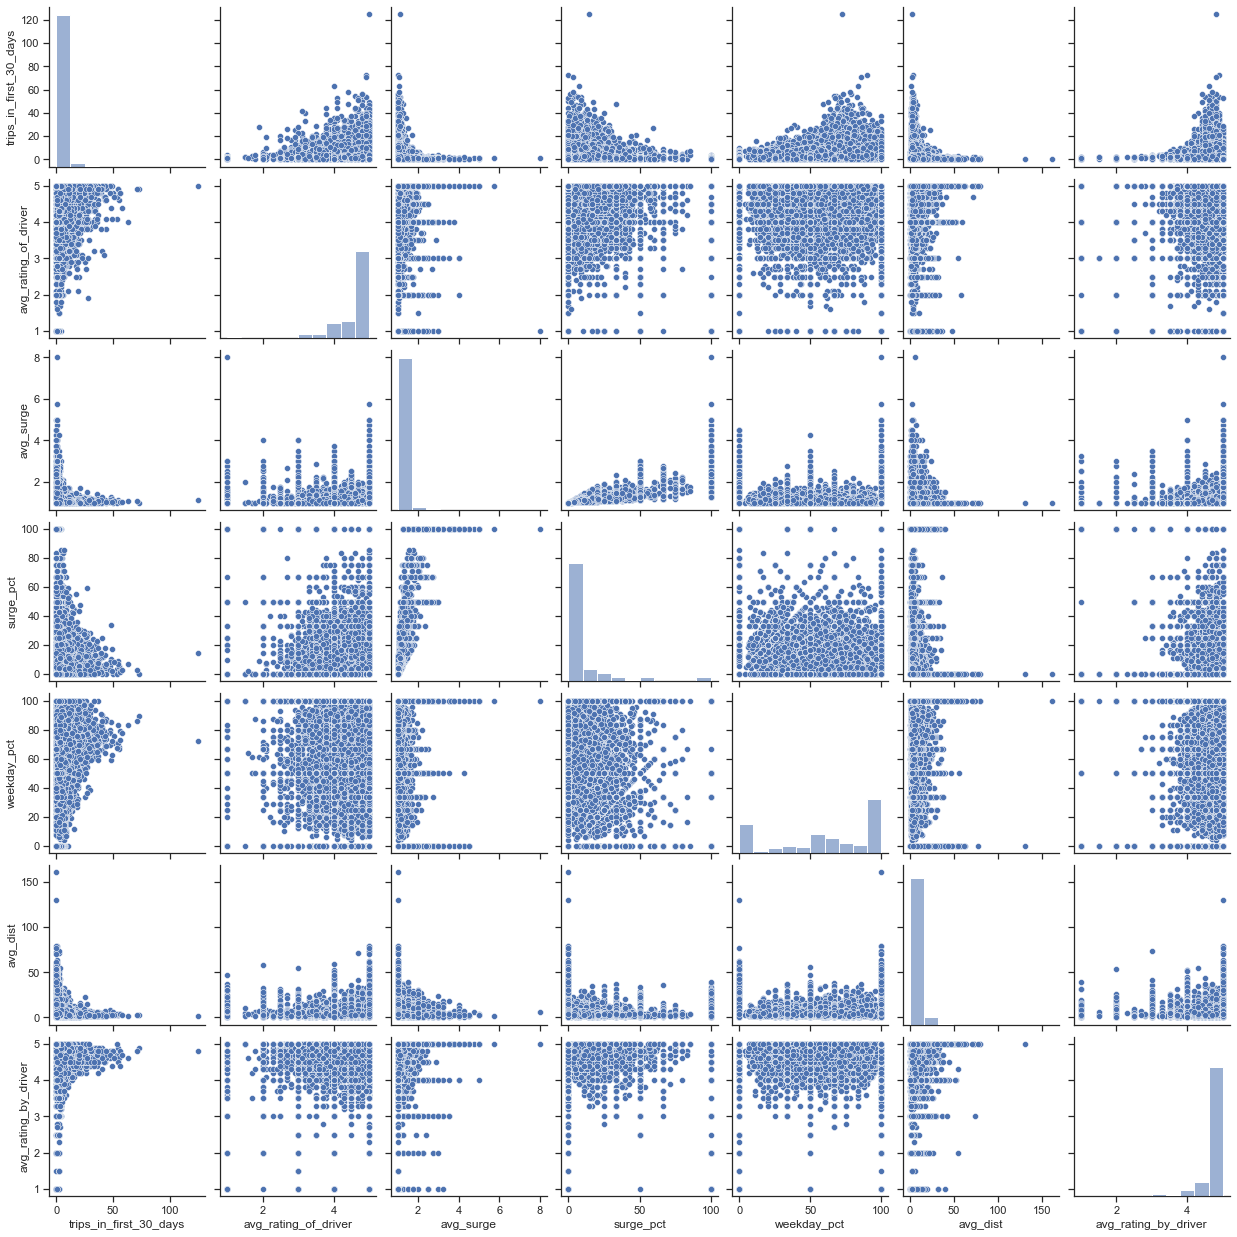

In [234]:
# Looking at the relation and distribution of data
sns.set(style="ticks", color_codes=True)
_ = sns.pairplot(data, diag_kws = {'alpha':0.55, 'bins':10})

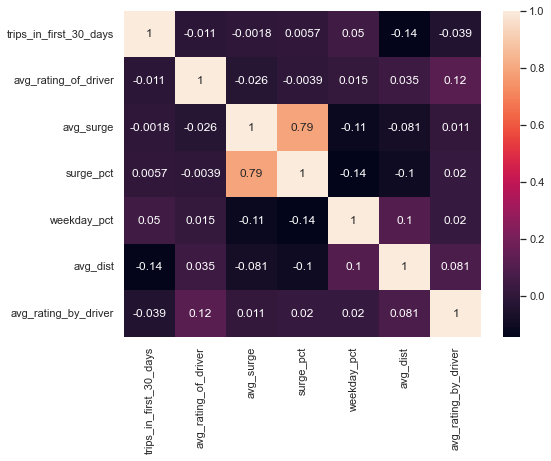

In [235]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(data.corr(), annot = True)
plt.show()

In [236]:
# Dealing with missing values in avg_rating_of_driver, phone and avg_rating_by_driver
missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by="count", ascending=False)

,count,%
avg_rating_of_driver,8122,16.244
phone,396,0.792
avg_rating_by_driver,201,0.402
city,0,0.000
trips_in_first_30_days,0,0.000
signup_date,0,0.000
avg_surge,0,0.000
last_trip_date,0,0.000
surge_pct,0,0.000
ultimate_black_user,0,0.000


iPhone     69.716152
Android    30.283848
Name: phone, dtype: float64


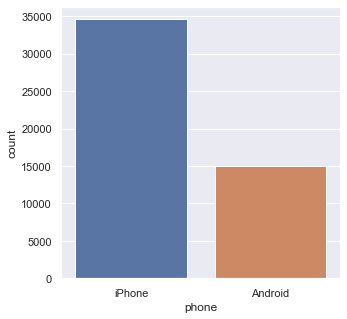

In [237]:
# Looking at the distribution of phone types
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(x = data["phone"])
print(data['phone'].value_counts(normalize=True)*100)

In [238]:
# Implementing missing values in 'phone' with the Frequent Categorical Imputation strategy
# where it is assumed that data is missing randomly and missing values look like the majority.
def frequent_categorical_imputation_nan(DataFrame,ColName):
     most_frequent_category=DataFrame[ColName].mode()[0]
     DataFrame[ColName + "_Imputed"] = DataFrame[ColName]
     DataFrame[ColName + "_Imputed"].fillna(most_frequent_category,inplace=True)

frequent_categorical_imputation_nan(data,'phone')

data = data.drop(['phone'], axis = 1)

In [239]:
# Implementing missing values in 'avg_rating_of_driver' and 'avg_rating_by_driver' with the median.
def median_imputation_nan(DataFrame,ColName):
    median = DataFrame[ColName].median()
    DataFrame[ColName + "_Imputed"] = DataFrame[ColName]
    DataFrame[ColName + "_Imputed"].fillna(median,inplace=True)

for Columns in ['avg_rating_of_driver', 'avg_rating_by_driver']:
    median_imputation_nan(data,Columns)


data = data.drop(['avg_rating_of_driver', 'avg_rating_by_driver'], axis = 1)

In [240]:
# Reverification of the missing values - There is none
missing = pd.concat([data.isnull().sum(), 100 * data.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by="count", ascending=False)

,count,%
city,0,0.0
trips_in_first_30_days,0,0.0
signup_date,0,0.0
avg_surge,0,0.0
last_trip_date,0,0.0
surge_pct,0,0.0
ultimate_black_user,0,0.0
weekday_pct,0,0.0
avg_dist,0,0.0
phone_Imputed,0,0.0


In [241]:
# Assign the active status to user who took a trip in the preceding 30 days
data['active'] = data['last_trip_date'].apply(lambda date: 0 if ((data['last_trip_date'].max())-date).days > 30 else 1)
data.head()

,city,trips_in_first_30_days,signup_date,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,phone_Imputed,avg_rating_of_driver_Imputed,avg_rating_by_driver_Imputed,active
0,King's Landing,4,2014-01-25,1.10,2014-06-17,15.4,True,46.2,3.67,iPhone,4.7,5.0,1
1,Astapor,0,2014-01-29,1.00,2014-05-05,0.0,False,50.0,8.26,Android,5.0,5.0,0
2,Astapor,3,2014-01-06,1.00,2014-01-07,0.0,False,100.0,0.77,iPhone,4.3,5.0,0
3,King's Landing,9,2014-01-10,1.14,2014-06-29,20.0,True,80.0,2.36,iPhone,4.6,4.9,1
4,Winterfell,14,2014-01-27,1.19,2014-03-15,11.8,False,82.4,3.13,Android,4.4,4.9,0


0.0    62.392
1.0    37.608
Name: active, dtype: float64


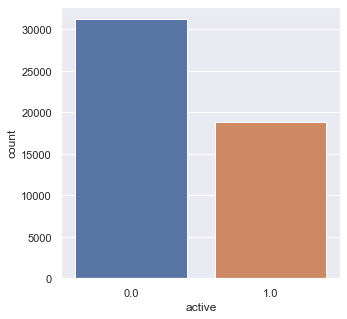

In [349]:
# Looking at the distribution of the activity status
sns.countplot(x = data["active"])
print(data['active'].value_counts(normalize=True)*100)

37.6% are considered as active (1), while 62.4% are inactive (0).

In [243]:
#create dummy variables for categorical features
data = pd.get_dummies(data,columns=['city','ultimate_black_user', 'phone_Imputed'])

In [244]:
data_dummy.head()

,trips_in_first_30_days,signup_date,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_of_driver_Imputed,avg_rating_by_driver_Imputed,active,city_Astapor,city_King's Landing,city_Winterfell,ultimate_black_user_False,ultimate_black_user_True,phone_Imputed_Android,phone_Imputed_iPhone
0,4,2014-01-25,1.10,2014-06-17,15.4,46.2,3.67,4.7,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,1.00,2014-05-05,0.0,50.0,8.26,5.0,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,1.00,2014-01-07,0.0,100.0,0.77,4.3,5.0,0,1,0,0,1,0,0,1
3,9,2014-01-10,1.14,2014-06-29,20.0,80.0,2.36,4.6,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,1.19,2014-03-15,11.8,82.4,3.13,4.4,4.9,0,0,0,1,1,0,1,0


In [245]:
# Converting datetime features to number
data["signup_date_year"] = data["signup_date"].dt.year
data["signup_date_month"] = data["signup_date"].dt.month
data["signup_date_week"] = data["signup_date"].dt.week
data["signup_date_day"] = data["signup_date"].dt.day
data["signup_date_hour"] = data["signup_date"].dt.hour
data["signup_date_minute"] = data["signup_date"].dt.minute
data["signup_date_weekday"] = data["signup_date"].dt.dayofweek

data["last_trip_date_year"] = data["last_trip_date"].dt.year
data["last_trip_date_month"] = data["last_trip_date"].dt.month
data["last_trip_date_week"] = data["last_trip_date"].dt.week
data["last_trip_date_day"] = data["last_trip_date"].dt.day
data["last_trip_date_hour"] = data["last_trip_date"].dt.hour
data["last_trip_date_minute"] = data["last_trip_date"].dt.minute
data["last_trip_date_weekday"] = data["last_trip_date"].dt.dayofweek

data = data.drop(["signup_date", "last_trip_date"], axis = 1)

C:\Users\laurence\AppData\Local\Temp/ipykernel_1708/402544534.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data["signup_date_week"] = data["signup_date"].dt.week
C:\Users\laurence\AppData\Local\Temp/ipykernel_1708/402544534.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data["last_trip_date_week"] = data["last_trip_date"].dt.week


In [224]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
features = ['avg_surge', 'surge_pct','weekday_pct', 'avg_dist','avg_rating_of_driver_Imputed', 'avg_rating_by_driver_Imputed']
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

In [246]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   trips_in_first_30_days        50000 non-null  int64  
 1   avg_surge                     50000 non-null  float64
 2   surge_pct                     50000 non-null  float64
 3   weekday_pct                   50000 non-null  float64
 4   avg_dist                      50000 non-null  float64
 5   avg_rating_of_driver_Imputed  50000 non-null  float64
 6   avg_rating_by_driver_Imputed  50000 non-null  float64
 7   active                        50000 non-null  int64  
 8   city_Astapor                  50000 non-null  uint8  
 9   city_King's Landing           50000 non-null  uint8  
 10  city_Winterfell               50000 non-null  uint8  
 11  ultimate_black_user_False     50000 non-null  uint8  
 12  ultimate_black_user_True      50000 non-null  uint8  
 13  p

In [247]:
# Converting the dataset into float
data = data.astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   trips_in_first_30_days        50000 non-null  float64
 1   avg_surge                     50000 non-null  float64
 2   surge_pct                     50000 non-null  float64
 3   weekday_pct                   50000 non-null  float64
 4   avg_dist                      50000 non-null  float64
 5   avg_rating_of_driver_Imputed  50000 non-null  float64
 6   avg_rating_by_driver_Imputed  50000 non-null  float64
 7   active                        50000 non-null  float64
 8   city_Astapor                  50000 non-null  float64
 9   city_King's Landing           50000 non-null  float64
 10  city_Winterfell               50000 non-null  float64
 11  ultimate_black_user_False     50000 non-null  float64
 12  ultimate_black_user_True      50000 non-null  float64
 13  p

In [249]:
# Spliting data into training and testing set
X = data.drop(['active', "last_trip_date_year", "last_trip_date_month", "last_trip_date_week", "last_trip_date_day", "last_trip_date_hour", "last_trip_date_minute", "last_trip_date_weekday"], axis = 1)
y = data.active

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Modeling

In [280]:
# Build a predictive model - random forest classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=3000)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)

21


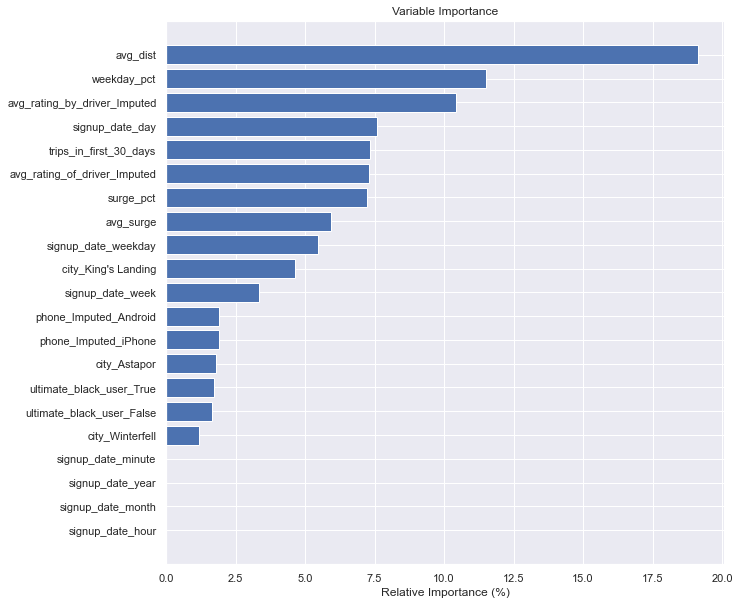

In [281]:
# Identification of the features having the most importance in the model
feature_importance = rfc.feature_importances_
feature_importance = 100.0 * (feature_importance)
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance (%)')
plt.title('Variable Importance')
plt.show()

 The importance of the feature is quite well spread. The feature having the most importance is "avg_dist", "weekday_pct" and "avg_rating_by_driver_imputed".

In [282]:
# Calculating the accuracy score of the model
rfc.score(X_test,y_test)

0.7696

In [299]:
# Calculating the mean cross-validated accuracy score
print(cross_val_score(rfc, X_test, y_test, cv=5))
print('Mean cross validated score:', np.mean(cross_val_score(rfc, X_test, y_test, cv=5)))

[0.761  0.772  0.7615 0.763  0.76  ]
Mean cross validated score: 0.764


The accuracy score of the model is ~77%, while the mean of the cross-validated score is 76%. This implies that the model have a constant score when trained on 5 different subsets.
This means that around 76% of predictions made by the model is correct.

In [321]:
# Calculating the confusion matrix for the tested and predicted features.
confusion_matrix(y_test, y_pred)

array([[5211, 1008],
       [1296, 2485]], dtype=int64)

In [325]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82      6219
         1.0       0.71      0.66      0.68      3781

    accuracy                           0.77     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.77      0.77      0.77     10000



In [327]:
# Hyperparameters tuning for the Random forest classifier
# Preparation of the grid to search for the best parameters.
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 10000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [332]:
# Initiating the random search model with 3 fold cross validation and fit.
search = RandomizedSearchCV(estimator = rfc,
                            param_distributions = random_grid,
                            n_iter = 100,
                            cv = 3,
                            verbose=2,
                            random_state=42,
                            n_jobs = -1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\laurence\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.782575          nan        nan 0.77962501 0.77674996
 0.76975    0.76962501 0.78205001 0.77967499 0.782575   0.77944999
 0.77874998 0.78227495 0.781975   0.769975   0.78269997 0.77419997
 0.75670003 0.76659998 0.7821     0.779875   0.77150001 0.78007501
 0.78145001 0.77647496 0.77962502 0.78182503 0.77737498 0.77892502
 0.77344998 0.77384998 0.77992499 0.76995    0.77319999 0.77955
 0.75830002 0.77997501 0.77959999 0.78127502 0.77834998 0.77847496
 0.75702505 0.76757498 0.78027499 0.78025001 0.77937499 0.78197501
 0.78227501 0.769375   0.78212503 0.767875   0.77975    0.782525
 0.7827     0.78009999        nan 0.770225          nan 0.77512492
 0.779525   0.77774998 0.77002499 0.777875   0.77969999 0.78170001
 0.78212498 0.77440001 0.774225   0.77752498 0.782275   0.77949998
 0.77012498 0.77757496 0.77972498 0.77789999 0.77907498

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=3000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 2575, 5050, 7525,
                                                         10000]},
                   random_state=42, verbose=2)

In [333]:
# Printing the best parameters.
search.best_params_

{'n_estimators': 10000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [334]:
y_pred = search.predict(X_test)

In [336]:
# Calculating the accuracy score of the tuned model
search.score(X_test,y_test)

0.7801

There is a slight improvement of the accuracy.

In [341]:
# Calculating the confusion matrix for the tested and predicted features of the tuned model
confusion_matrix(y_test, y_pred)

array([[5343,  876],
       [1323, 2458]], dtype=int64)

In [342]:
# Classification report of the tuned model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      6219
         1.0       0.74      0.65      0.69      3781

    accuracy                           0.78     10000
   macro avg       0.77      0.75      0.76     10000
weighted avg       0.78      0.78      0.78     10000



The random forest classifier results are quite good, but not great. We should verify if basic logistic regression give a similar result.

In [344]:
# Testing logistic regression modeling
logr = linear_model.LogisticRegression()
logr.fit(X_train, y_train)
y_pred = logr.predict(X_test)

C:\Users\laurence\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [346]:
# Calculating the accuracy score of the model
logr.score(X_test,y_test)

0.7102

In [347]:
# Calculating the confusion matrix for the tested and predicted features of the model
confusion_matrix(y_test, y_pred)

array([[5210, 1009],
       [1889, 1892]], dtype=int64)

In [348]:
# Classification report of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.84      0.78      6219
         1.0       0.65      0.50      0.57      3781

    accuracy                           0.71     10000
   macro avg       0.69      0.67      0.67     10000
weighted avg       0.70      0.71      0.70     10000



There is a considerable drop in the accuracy score, but type 1 and 2 errors are in the same range or slightly better. If there is a necessity to have a better accuracy score, random forest classifier should be used, but if an accuracy around 71% is sufficient, logistic regression could be used with a considerable lower operational cost.

Exploration of the hyperparameters of the random forest classifier could have been done further, providing a more powerful computer, as well as for the logistic regression model.

There is a clear link between the average distance and the active status of a rider. More work could be done to better understand the relation between the two features in order to incresse the number of active rider.
App use during the weekday vs weekend also seems to be an important insight that could be explore further. Incitative during certain days could be a solution to again increase the number of active rider.